In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib 
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
import math
import random
import warnings

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler

import shap
import mplcyberpunk
import xgboost as xgb
from lightgbm import LGBMClassifier

import tensorflow as tf
import keras
from keras import Model
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from keras.layers import Dense, Input, InputLayer, Add, Concatenate
from keras.utils.vis_utils import plot_model

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

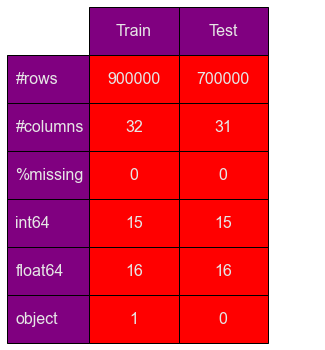

In [2]:
#1.1 Perform eda on data
#interaction vs. correlation
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.style.use("cyberpunk")
# runtime configuration of matplotlib
plt.rc("figure", 
    autolayout=False, 
    figsize=(20, 10),
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=20,
    titlepad=10,
)
train_raw = pd.read_csv('train.csv',index_col='id')
#create table
fig = plt.figure(figsize=(5, 2))
ax = fig.add_subplot(111)

table_vals = [[900000, 700000], [32, 31], [0, 0], [15, 15], [16, 16], [1, 0]]

# Draw table
the_table = plt.table(cellText=table_vals,
                      colWidths=[0.08]*2,
                      rowLabels=['#rows', '#columns', '%missing', "int64", "float64", "object"],
                      colLabels=['Train', 'Test'],
                      loc='center',
                      cellLoc='center',
                      rowColours =["purple"] * 6,  
                      colColours =["purple"] * 6,
                      cellColours=[['r', 'r'], ['r', 'r'], ['r', 'r'], ['r', 'r'], ['r', 'r'], ['r', 'r']]
                      )
the_table.auto_set_font_size(False)
the_table.set_fontsize(16)
the_table.scale(4, 4)
ax.grid(False)
ax.axis('tight')
ax.axis('off')
plt.show()

In [3]:
#1.2 Modelling for SHAP


# From https://www.kaggle.com/ambrosm/tpsmay22-eda-which-makes-sense
for i in range(10):
    train_raw[f'ch{i}'] = train_raw.f_27.str.get(i).apply(ord) - ord('A')
    train_raw["unique_characters"] = train_raw.f_27.apply(lambda s: len(set(s)))

features = [col for col in train_raw.columns if col != "target" and col !="f_27"]
X=train_raw[features]
y=train_raw["target"]
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.4, random_state = 42)

# Train model
lgbm_model =LGBMClassifier(n_estimators=5000, min_child_samples=80, random_state=1307)
lgbm_model.fit(X_train.values, y_train)
y_val_pred = lgbm_model.predict_proba(X_val.values)[:,1]
score = roc_auc_score(y_val, y_val_pred)
print(f"Validation AUC:{(score):.3f}")

Validation AUC:0.990


In [4]:
#SHAP interaction values
#from https://www.kaggle.com/code/wti200/analysing-interactions-with-shap

# Using a random sample of the dataframe for better time computation
X_sampled = X_val.sample(20000, random_state=1307)

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_sampled)

#Get SHAP interaction values. Beware it is time consuming to calculate the interaction values.
shap_interaction = explainer.shap_interaction_values(X_sampled)
print(np.shape(shap_interaction))

(20000, 41, 41)


In [11]:
shap_interaction = np.savetxt("shap_interaction_20k.txt", X)

In [14]:
loaded_arr = np.loadtxt('shap-interaction-20k.txt')
load_original_arr = loaded_arr.reshape(
    #loaded_arr.shape[0], loaded_arr.shape[1] // shap_interaction.shape[2], shap_interaction.shape[2])
    loaded_arr.shape[0], loaded_arr.shape[1] // 41, 41)

shap_interaction = load_original_arr

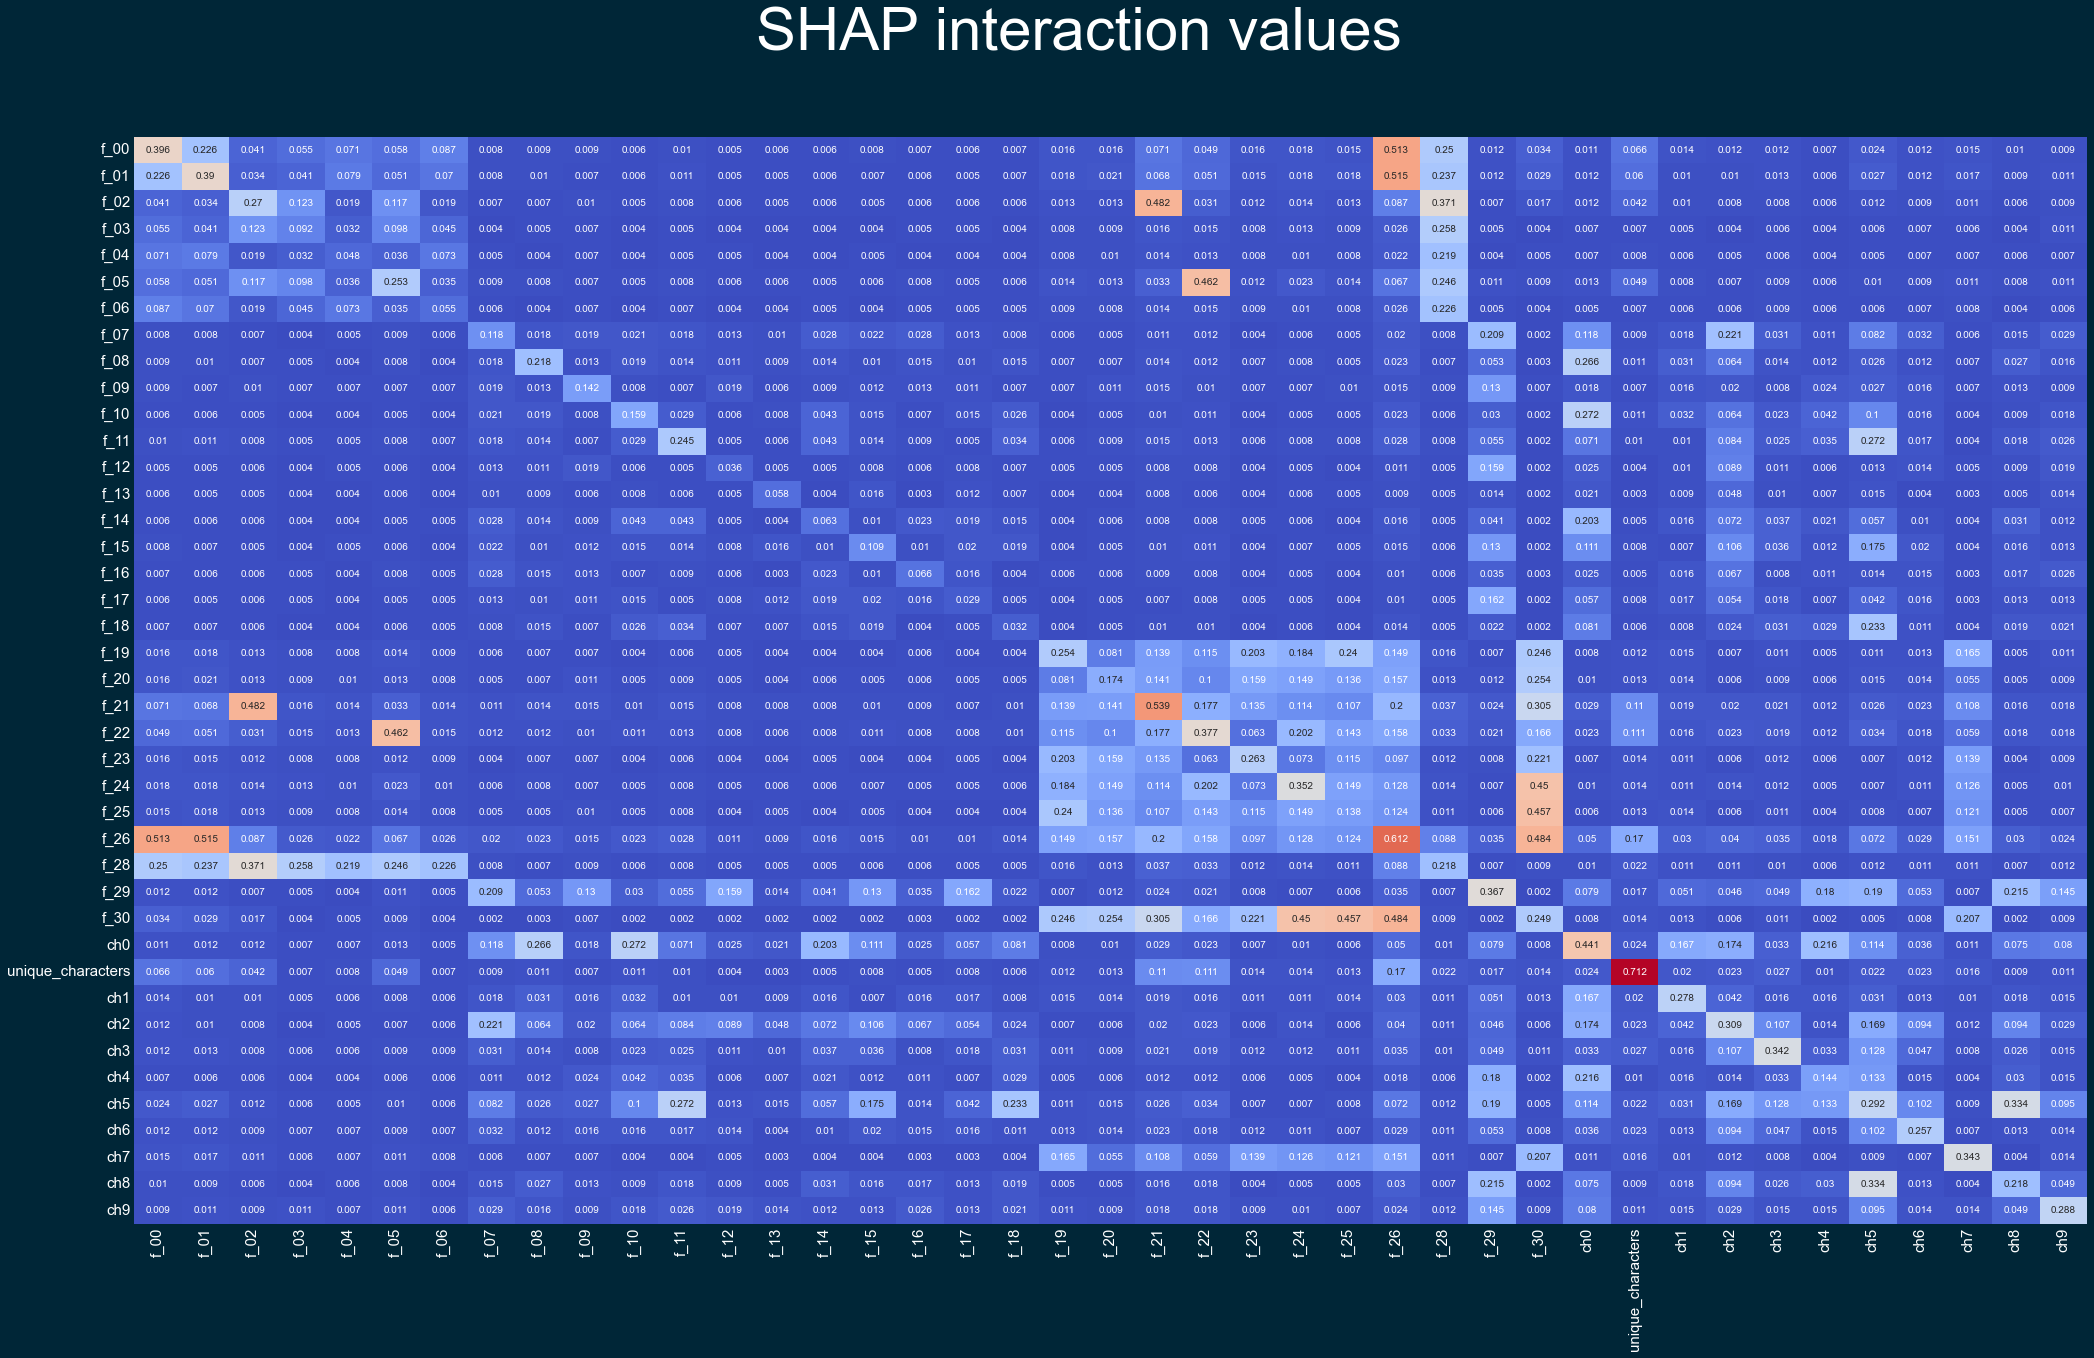

In [15]:
#absolute mean plot
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap, index=X.columns, columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2, inplace=True)

# display 
fig = plt.figure(figsize=(35, 20), facecolor='#002637', edgecolor='r')
ax = fig.add_subplot()
sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=False, ax=ax, )
ax.tick_params(axis='x', colors='w', labelsize=15, rotation=90)
ax.tick_params(axis='y', colors='w', labelsize=15)

plt.suptitle("SHAP interaction values", color="white", fontsize=60, y=0.97)
plt.yticks(rotation=0) 
plt.show()

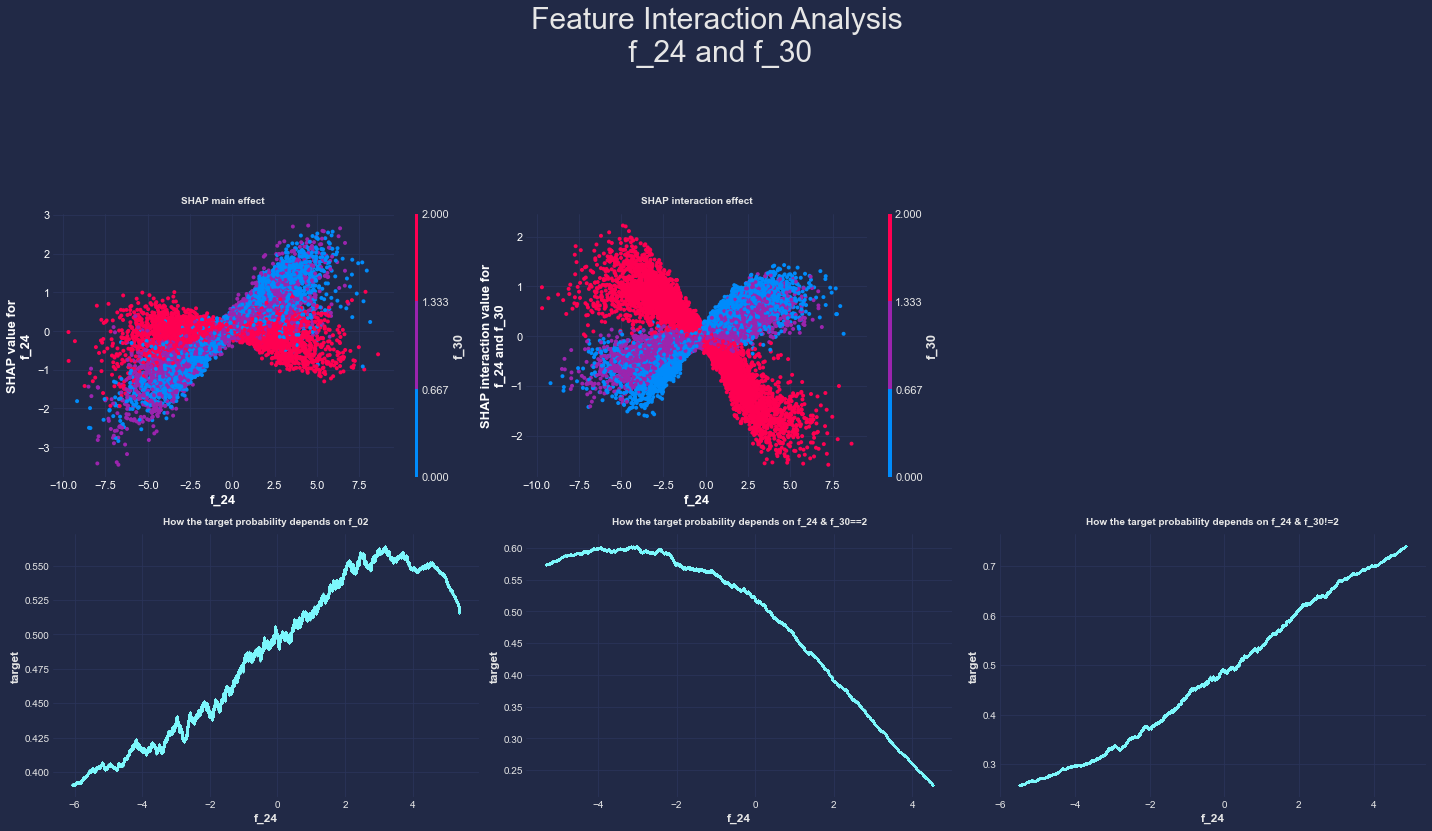

In [16]:
#feature interaction analysis
#plot feature interaction
def plot_feature_interaction(f1, f2):
    # dependence plot
    fig = plt.figure(tight_layout=True, figsize=(20,10))
    spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)


    ax0 = fig.add_subplot(spec[0, 0])
    minv, maxv = np.percentile(X_sampled, [1, 99])
    shap.dependence_plot(f1, shap_values[1], X_sampled, display_features=X_sampled, interaction_index=f2, ax=ax0, show=False)
    ax0.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax0.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax0.set_title(f'SHAP main effect', fontsize=10)

    ax1 = fig.add_subplot(spec[0, 1])
    shap.dependence_plot((f1, f2), shap_interaction, X_sampled, display_features=X_sampled, ax=ax1, axis_color='w', show=False)
    ax1.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax1.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax1.set_title(f'SHAP interaction effect', fontsize=10)


    temp = pd.DataFrame({f1: train_raw[f1].values,
                    'target': train_raw.target.values})
    temp = temp.sort_values(f1)
    temp.reset_index(inplace=True)
    
    ax3 = fig.add_subplot(spec[1, 0])
    sns.scatterplot(x=temp[f1], y=temp.target.rolling(15000, center=True).mean(), data=temp, ax=ax3, s=2)
    ax3.set_title('How the target probability depends on f_02', fontsize=10)

    temp = pd.DataFrame({f1: train_raw.loc[train_raw["f_30"]==2,f1].values,
                    'target': train_raw.loc[train_raw["f_30"]==2,'target'].values})
    temp = temp.sort_values(f1)
    temp.reset_index(inplace=True)
    
    ax4 = fig.add_subplot(spec[1, 1])
    sns.scatterplot(x=temp[f1], y=temp.target.rolling(15000, center=True).mean(), data=temp, ax=ax4, s=2)
    ax4.set_title('How the target probability depends on f_24 & f_30==2', fontsize=10)


    temp = pd.DataFrame({f1: train_raw.loc[train_raw["f_30"]!=2,f1].values,
                    'target': train_raw.loc[train_raw["f_30"]!=2,'target'].values})
    temp = temp.sort_values(f1)
    temp.reset_index(inplace=True)
    
    ax5 = fig.add_subplot(spec[1, 2])
    sns.scatterplot(x=temp[f1], y=temp.target.rolling(15000, center=True).mean(), data=temp, ax=ax5, s=2)
    ax5.set_title('How the target probability depends on f_24 & f_30!=2', fontsize=10)
    
    plt.suptitle("Feature Interaction Analysis\n f_24 and f_30", fontsize=30, y=1.15)
    fig.tight_layout()

    plt.show()

plt.style.use("cyberpunk")

f1='f_24'
f2='f_30'
plot_feature_interaction(f1, f2)

findfont: Font family ['smallcaps'] not found. Falling back to DejaVu Sans.


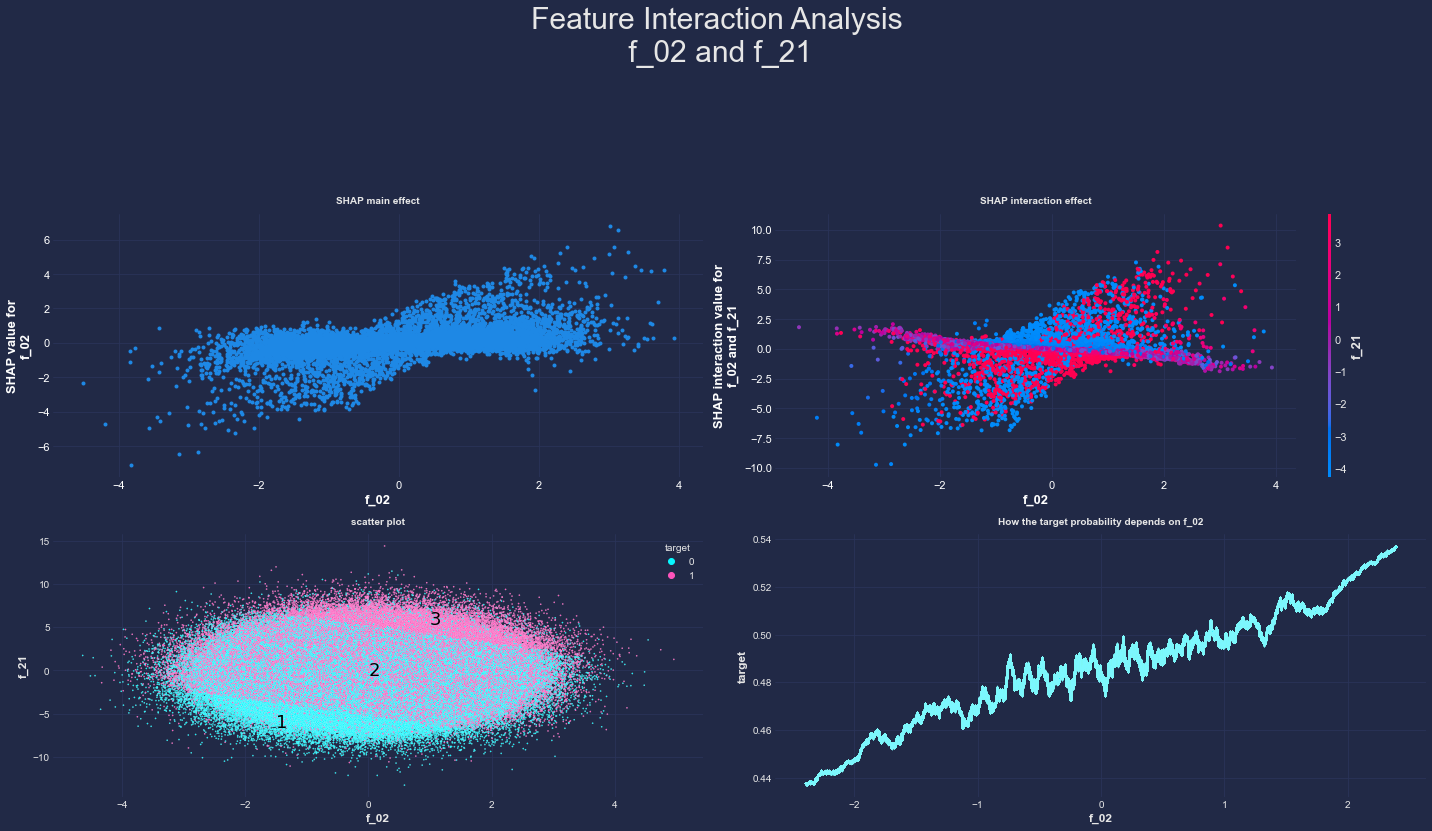

In [17]:
#More on local effect levels
#plot function
plt.style.use("cyberpunk")

def plot_feature_interaction(f1, f2):
    # dependence plot
    fig = plt.figure(tight_layout=True, figsize=(20,10))
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)


    ax0 = fig.add_subplot(spec[0, 0])
    shap.dependence_plot(f1, shap_values[1], X_sampled, display_features=X_sampled, interaction_index=None, ax=ax0, show=False)
    ax0.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax0.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax0.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax0.set_title(f'SHAP main effect', fontsize=10)

    ax1 = fig.add_subplot(spec[0, 1])
    shap.dependence_plot((f1, f2), shap_interaction, X_sampled, display_features=X_sampled, ax=ax1, axis_color='w', show=False)
    ax1.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.xaxis.label.set_color('white')          #setting up Y-axis label color to blue
    ax1.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
    ax1.tick_params(axis='y', colors='white')    #setting up X-axis tick color to red
    ax1.set_title(f'SHAP interaction effect', fontsize=10)

    ax2 = fig.add_subplot(spec[1, 0])
    sns.scatterplot(x=f1, y=f2, data=train_raw, hue="target", ax=ax2, s=2)
    ax2.text(-1.5, -5, "1", fontsize=18, verticalalignment='top', rotation="horizontal", color="k", fontproperties="smallcaps")
    ax2.text(0, 1, "2", fontsize=18, verticalalignment='top', rotation="horizontal", color="k", fontproperties="smallcaps")
    ax2.text(1, 7, "3", fontsize=18, verticalalignment='top', rotation="horizontal", color="k", fontproperties="smallcaps")

    ax2.set_title(f'scatter plot', fontsize=10)

    temp = pd.DataFrame({f1: train_raw[f1].values,'target': train_raw.target.values})
    temp = temp.sort_values(f1)
    temp.reset_index(inplace=True)
    
    ax3 = fig.add_subplot(spec[1, 1])
    sns.scatterplot(x=temp[f1], y=temp.target.rolling(15000, center=True).mean(), data=temp, ax=ax3, s=2)
    ax3.set_title('How the target probability depends on f_02', fontsize=10)
    
    plt.suptitle("Feature Interaction Analysis\n f_02 and f_21", fontsize=30, y=1.15)
    plt.show()

f1='f_02'
f2='f_21'
plot_feature_interaction(f1, f2)